# Treinamento do modelo EfficientNetV2

Este notebook é a versão interativa do script de treinamento `EfficientNetV2.py`. Ele treina um classificador binário (cálculo renal: 1 / normal: 0) usando backbones EfficientNetV2 e lê os arquivos `train{i}.csv` / `val{i}.csv`.

**Como usar:** defina a célula de configuração e execute as células em ordem. O notebook salvará as saídas (modelos, métricas JSON) no `output_root` especificado.


In [1]:
import json
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print('TensorFlow version:', tf.__version__)


2025-10-14 03:09:36.450859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-14 03:09:36.466549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-14 03:09:36.470501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-14 03:09:36.481257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponíveis: {gpus}")
else:
    print("Nenhuma GPU encontrada.")


GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1760422178.364174    5782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760422178.420534    5782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760422178.420626    5782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.


## Configurações

In [3]:
DATASET_ROOT = Path.cwd().parent / '1-dataset-processing' / 'data' / 'dataset-article' / 'dataset-224'
OUTPUT_ROOT = Path('outputs')

MODEL_NAME = 'EfficientNetV2S'
# MODEL_NAME = 'EfficientNetV2M'

EPOCHS = 12
BATCH_SIZE = 32

LR = None  # e.g. 1e-4
FOLDS = 5

OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
print('Pasta do Dataset:', DATASET_ROOT)
print('Pasta para o Output:', OUTPUT_ROOT)


Pasta do Dataset: /mnt/c/Users/gnmis/OneDrive/Documentos/Faculdade/LocalVsGlobalKidneyStone-tests/1-dataset-processing/data/dataset-article/dataset-224
Pasta para o Output: outputs


## Definição do modelo

https://github.com/leondgarse/keras_efficientnet_v2

In [4]:
MODEL_MAP = {
    'EfficientNetV2S': tf.keras.applications.efficientnet_v2.EfficientNetV2S,
    'EfficientNetV2M': tf.keras.applications.efficientnet_v2.EfficientNetV2M
# Adicionar outros modelos AQUI e lembrar de trocar o nome do usado atualmente
}
MODEL_MAP_SIZE =  {
    'EfficientNetV2S': (384, 384),
    'EfficientNetV2M': (480, 480)
# Adicionar outros modelos AQUI e lembrar de trocar o nome do usado atualmente
}

IMG_SIZE = MODEL_MAP_SIZE.get(MODEL_NAME, (224, 224))
if MODEL_NAME not in MODEL_MAP_SIZE:
    print(f"Warning: {MODEL_NAME} not found in MODEL_MAP_SIZE — falling back to {IMG_SIZE}")
else:
    print(f"Using IMG_SIZE = {IMG_SIZE} for model {MODEL_NAME}")

def build_model(model_name, input_shape=(IMG_SIZE), dropout=0.3):
    if model_name not in MODEL_MAP:
        raise ValueError(f"Unknown model_name: {model_name}. Available: {list(MODEL_MAP.keys())}")
    backbone_cls = MODEL_MAP[model_name]
    backbone = backbone_cls(include_top=False, input_shape=input_shape, weights='imagenet', pooling='avg')

    inputs = tf.keras.Input(shape=input_shape)
    x = backbone(inputs, training=False)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs, name=f"{model_name}_bincls")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )
    return model

print('Definição do modelo pronta')


Using IMG_SIZE = (384, 384) for model EfficientNetV2S
Definição do modelo pronta


## Ler arquivos `.csv` e imagens do Dataset

In [5]:
def read_csv(csv_path, dataset_root):
    df = pd.read_csv(csv_path)
    if df.shape[1] >= 2:
        filename_col = df.columns[0]
        label_col = df.columns[1]
    else:
        raise ValueError(f"CSV {csv_path} must have at least 2 columns: filename,label")

    filepaths = []
    for fn in df[filename_col].astype(str).tolist():
        p = Path(fn)
        if p.exists():
            filepaths.append(str(p))
        else:
            candidate = Path(dataset_root) / fn
            if candidate.exists():
                filepaths.append(str(candidate))
            else:
                found = None
                for sub in ['with-stone', 'without-stone']:
                    cand2 = Path(dataset_root) / sub / fn
                    if cand2.exists():
                        found = cand2
                        break
                if found:
                    filepaths.append(str(found))
                else:
                    raise FileNotFoundError(f"Could not resolve path for {fn} (csv: {csv_path})")

    labels = df[label_col].astype(int).tolist()
    return filepaths, labels

print('Arquivos `.csv` prontos')


Arquivos `.csv` prontos


In [6]:
def make_dataset(filepaths, labels, img_size, batch_size=32, shuffle=True, augment=False, seed=123, zoom_out_factor=0.2, contrast_factor=0.2, brightness_delta=0.2):
    AUTOTUNE = tf.data.AUTOTUNE

    def _load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)  # -> [0,1]
        img = tf.image.resize(img, img_size)
        return img, tf.cast(label, tf.int32)

    ds = tf.data.Dataset.from_tensor_slices((list(filepaths), list(labels)))
    if shuffle:
        try:
            buffer = min(10000, len(filepaths))
        except Exception:
            buffer = 1000
        ds = ds.shuffle(buffer_size=buffer, seed=seed)

    ds = ds.map(_load_image, num_parallel_calls=AUTOTUNE)

    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomZoom(height_factor=(0.0, zoom_out_factor), width_factor=(0.0, zoom_out_factor)),
            tf.keras.layers.RandomContrast(contrast_factor),
            tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=brightness_delta)),
        ], name="data_augmentation")
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

print('Imagens de treino e teste prontas')


Imagens de treino e teste prontas


## Apresentar imagens de treino e teste

In [7]:
def plot_dataset_images(dataset, class_names=None, n=64, title='Samples', seed=None):
    cols = int(math.sqrt(n))
    cols = max(1, cols)
    rows = math.ceil(n / cols)

    ds = dataset.unbatch()
    if seed is not None:
        ds = ds.shuffle(buffer_size=1000, seed=seed)
    ds = ds.take(n)

    images = []
    labels = []
    for img, lbl in ds:
        images.append(img.numpy())
        labels.append(int(lbl.numpy()))

    actual_n = len(images)
    if actual_n == 0:
        raise ValueError(f"Dataset didn't returned images. Verify if the dataset is correct.")
    cols = int(math.sqrt(actual_n))
    cols = max(1, cols)
    rows = math.ceil(actual_n / cols)

    plt.figure(figsize=(cols * 1.8, rows * 1.8))
    for i, (im, lbl) in enumerate(zip(images, labels)):
        ax = plt.subplot(rows, cols, i+1)
        if im.dtype == np.float32 or im.dtype == np.float64:
            vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = 0, 255
        if im.ndim == 3 and im.shape[2] == 1:
            im = im.squeeze(axis=2)
            ax.imshow(im, cmap='gray', vmin=vmin, vmax=vmax)
        else:
            ax.imshow(im, vmin=vmin, vmax=vmax)
        ax.axis('off')
        if class_names is not None and lbl < len(class_names):
            ax.set_title(class_names[lbl], fontsize=8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Salvar métricas

In [8]:
def compute_metrics_and_confmat(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)
    acc = float(accuracy_score(y_true, y_pred))
    prec = float(precision_score(y_true, y_pred, zero_division=0))
    rec = float(recall_score(y_true, y_pred, zero_division=0))
    f1 = float(f1_score(y_true, y_pred, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = int(cm[0,0]), int(cm[0,1]), int(cm[1,0]), int(cm[1,1])
    tnr = (tn / (tn + fp)) if (tn + fp) > 0 else 0.0
    return {
        'accuracy': acc,
        'precision': prec,
        'true_negative_rate': float(tnr),
        'recall': rec,
        'f1_score': f1
    }, {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

print('Escolha de métricas pronta')


Escolha de métricas pronta


## Looping de treino

Aqui se aciona o pipeline: para cada subdataset (arquivo de imagem do Dataset que esteja citado no `.csv`), ele lê os arquivos em questão, treina o modelo, salva o melhor modelo e grava as métricas em um arquivo `.json`.

In [9]:
def process_dataset(dataset_root, output_root, model_name, epochs, batch_size, img_size, lr, folds=5):
    dataset_root = Path(dataset_root)
    output_root = Path(output_root)

    potential = list(dataset_root.glob('train0.csv'))
    subdatasets = []
    if potential:
        subdatasets = [dataset_root]
    else:
        for sub in dataset_root.iterdir():
            if sub.is_dir() and (sub / 'train0.csv').exists():
                subdatasets.append(sub)

    if not subdatasets:
        raise FileNotFoundError(f"No train0.csv found in {dataset_root} or its immediate subfolders.")

    for sub in subdatasets:
        print(f"\n--- Processing subdataset: {sub} ---")

        metrics_agg = { 'accuracy': [], 'precision': [], 'true_negative_rate': [], 'recall': [], 'f1_score': [] }

        existing_folds = []
        for fold in range(folds):
            fold_out = output_root / f"fold{fold}"
            metrics_file = fold_out / "metrics.json"
            if fold_out.exists() and metrics_file.exists():
                print(f"Fold {fold} já processado. Pulando.")
                existing_folds.append(fold)

        for fold in range(folds):
            if fold in existing_folds:
                continue  # Pula folds já processados

            train_csv = sub / f"train{fold}.csv"
            val_csv = sub / f"val{fold}.csv"
            if not train_csv.exists() or not val_csv.exists():
                print(f"Skipping fold {fold}: missing {train_csv} or {val_csv}")
                continue

            fold_out = output_root / f"fold{fold}"
            fold_out.mkdir(parents=True, exist_ok=True)

            print(f"\nFold {fold}: reading csvs")
            train_files, train_labels = read_csv(train_csv, sub)
            val_files, val_labels = read_csv(val_csv, sub)

            try:
                classes = np.unique(train_labels)
                cw = compute_class_weight('balanced', classes=classes, y=train_labels)
                class_weight = {int(c): float(w) for c,w in zip(classes,cw)}
            except Exception as e:
                print(f"Warning: could not compute class weights, proceeding without. Error:", e)
                class_weight = None

            train_ds = make_dataset(train_files, train_labels, img_size=img_size, batch_size=batch_size, shuffle=True, augment=True)
            val_ds = make_dataset(val_files, val_labels, img_size=img_size, batch_size=batch_size, shuffle=False, augment=False)

            class_names = ['normal', 'stone']

            print("Apresentando imagens de treino")
            plot_dataset_images(train_ds, class_names=class_names, n=36, title='Train samples', seed=53)

            print("Apresentando imagens de validação")
            plot_dataset_images(val_ds, class_names=class_names, n=36, title='Validation samples', seed=53)

            input_shape = (img_size[0], img_size[1], 3)
            model = build_model(model_name, input_shape=input_shape)

            best_model_path = fold_out / f"best_model_fold{fold}.keras"
            cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(str(best_model_path), monitor='val_loss', save_best_only=True)
            cb_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=False)
            cb_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

            if lr is not None:
                tf.keras.backend.set_value(model.optimizer.lr, lr)

            print(f"Training fold {fold} (epochs={epochs}, batch_size={batch_size})")
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=epochs,
                callbacks=[cb_checkpoint, cb_early, cb_rlr],
                class_weight=class_weight,
                verbose=2
            )

            if best_model_path.exists():
                print("Loading best model from", best_model_path)
                model = tf.keras.models.load_model(str(best_model_path))

            y_probs = model.predict(val_ds, verbose=0)
            y_probs = np.asarray(y_probs).reshape(-1)
            y_true = np.array(val_labels)

            metrics, conf = compute_metrics_and_confmat(y_true, y_probs)
            print(f"Fold {fold} metrics:", metrics)

            for k in metrics_agg.keys():
                metrics_agg[k].append(metrics[k])

            metrics_file = fold_out / "metrics.json"
            with open(metrics_file, 'w') as f:
                json.dump(metrics, f, indent=2)

            cm_file = fold_out / "confusion_matrix.json"
            with open(cm_file, 'w') as f:
                json.dump(conf, f, indent=2)

            print(f"Saved fold {fold} metrics to {metrics_file} and confusion matrix to {cm_file}")

        agg_file = output_root / 'val-metrics-agg.json'
        with open(agg_file, 'w') as f:
            json.dump(metrics_agg, f, indent=2)
        print(f"Saved aggregated metrics to {agg_file}")

print('Looping de treino pronto')


Looping de treino pronto


In [10]:
dataset_root = Path(DATASET_ROOT)

def find_train_csvs(dataset_root):
    dataset_root = Path(dataset_root)
    return sorted(list(dataset_root.glob('**/train*.csv'))) # Busca arquivos train*.csv em dataset_root e em subpastas

train_csvs = find_train_csvs(dataset_root)
print("Arquivos train*.csv encontrados:")

if len(train_csvs) == 0:
    raise FileNotFoundError(f"No train*.csv found in {dataset_root} or subfolders. Check DATASET_ROOT.")

train_csv = train_csvs[0]
print("Usando CSV:", train_csv)

Arquivos train*.csv encontrados:
Usando CSV: /mnt/c/Users/gnmis/OneDrive/Documentos/Faculdade/LocalVsGlobalKidneyStone-tests/1-dataset-processing/data/dataset-article/dataset-224/.ipynb_checkpoints/train0-checkpoint.csv


## Rodar o _pipeline_

Rode para começar o treinamento. Lembre-se que os arquivos .csv e as imagens devem estar alocadas corretamente no caminho indicado pela variável `DATASET_ROOT`.


--- Processing subdataset: /mnt/c/Users/gnmis/OneDrive/Documentos/Faculdade/LocalVsGlobalKidneyStone-tests/1-dataset-processing/data/dataset-article/dataset-224 ---
Fold 0 já processado. Pulando.
Fold 1 já processado. Pulando.

Fold 2: reading csvs


I0000 00:00:1760422200.550065    5782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760422200.550175    5782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760422200.550234    5782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760422200.722131    5782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760422200.722240    5782 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14

Apresentando imagens de treino


2025-10-14 03:10:05.511378: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05580297..0.46992227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.001493603..1.0678239].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15061165..1.2180772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0846736..1.1610456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1830038..1.3109766].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

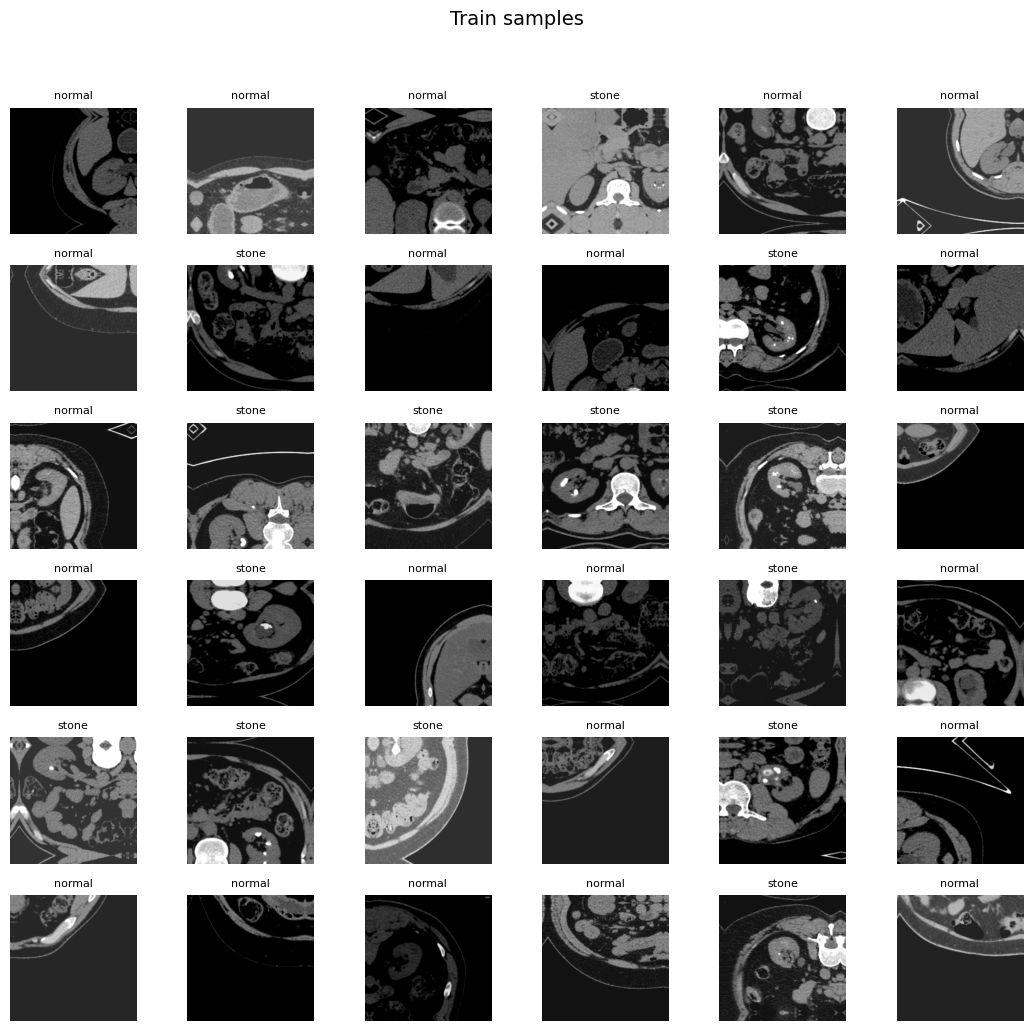

Apresentando imagens de validação


2025-10-14 03:10:13.013150: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


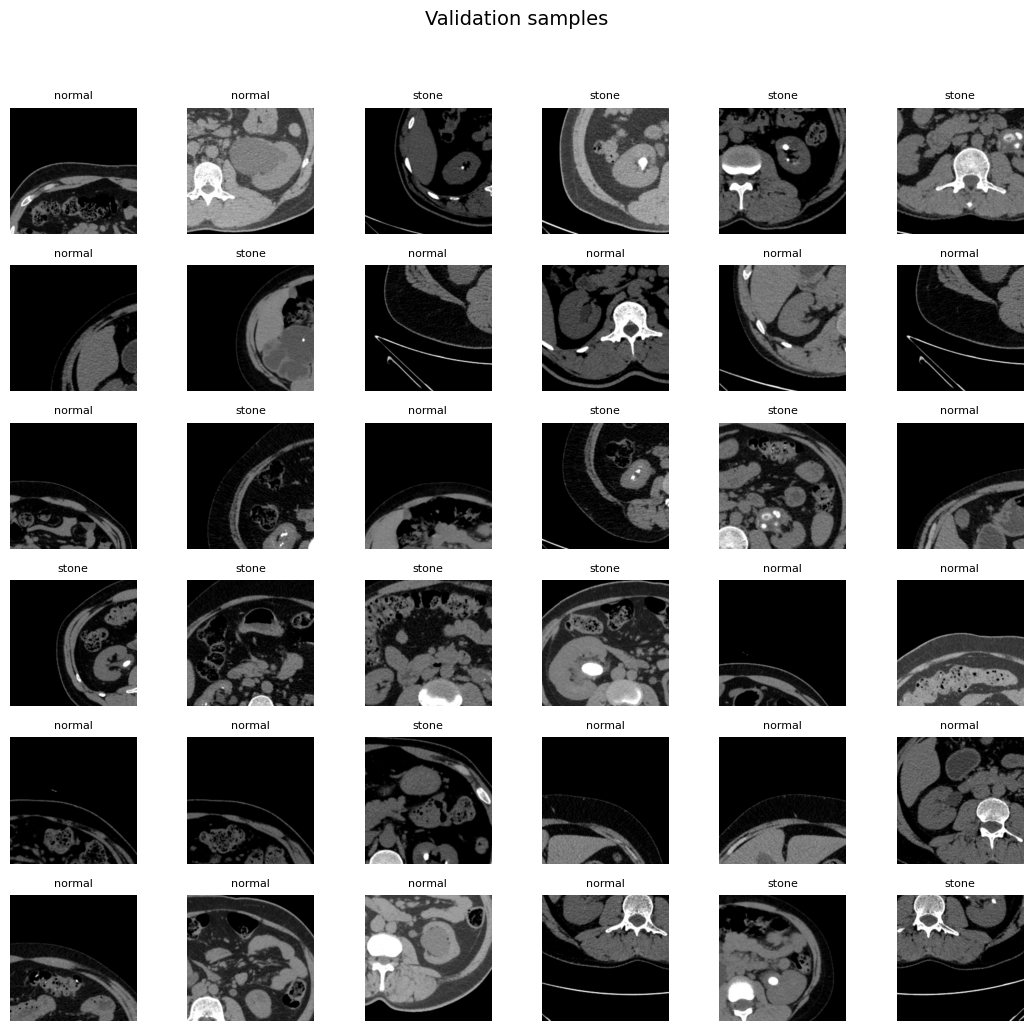

Training fold 2 (epochs=12, batch_size=32)
Epoch 1/12


I0000 00:00:1760422261.779387    5842 service.cc:146] XLA service 0x7ac0b0004c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760422261.779437    5842 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-10-14 03:11:05.245409: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-14 03:11:12.534507: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-10-14 03:11:28.374282: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng34{k2=2,k4=0,k5=0,k6=0,k7=0,k19=0} for conv (f32[32,24,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,385,385]{3,2,1,0}, f32[24,3,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0

In [ ]:
process_dataset(
    dataset_root=DATASET_ROOT,
    output_root=OUTPUT_ROOT,
    model_name=MODEL_NAME,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    lr=LR,
    folds=FOLDS
)
